In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

import statsmodels.api as sm
import statsmodels.tsa.api as smt

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings('ignore') 
warnings.simplefilter("ignore", ConvergenceWarning)

## Data Cleaning

In [2]:
df = pd.read_csv('parkingLot.csv', dtype={'camera_id': str}) 

df_entry = df[df['camera_id'] == '001'].sort_values(by='vehicle_no')
df_entry.reset_index(drop = True, inplace = True)
# df_entry.to_csv('parkingLot_camera_001.csv', index=False)

df_exit = df[df['camera_id'] == '002'].sort_values(by='vehicle_no')
df_exit.reset_index(drop = True, inplace = True)
# df_exit.to_csv('parkingLot_camera_002.csv', index=False)

duplicates = df['vehicle_no'].value_counts()[df['vehicle_no'].value_counts()%2 != 0]
print(duplicates.shape[0])


dd3 = pd.DataFrame({
    'vehicle_no': ['MHWW1113', 'MHPY2628', 'MHBK0188', 'MHKA6372', 'MHYV2746', 'MHPH6142', 'MHSM0215', 'MHNO9764', 'MHCZ2221'],
    'timestamp': ['2024-10-19 14:00:00', '2024-11-09 14:00:00', '2024-10-07 14:20:00', '2024-10-26 17:20:00', '2024-11-09 13:00:00', '2024-09-28 14:00:00', '2024-09-30 05:40:00', '2024-09-14 15:20:00', '2024-10-05 17:00:00'],
    'camera_id': ['002', '002', '001', '002', '002', '002', '001', '001', '002']
})

unique_001 = df_entry[~df_entry['vehicle_no'].isin(df_exit['vehicle_no'])].sort_values(by='vehicle_no')
unique_002 = df_exit[~df_exit['vehicle_no'].isin(df_entry['vehicle_no'])].sort_values(by='vehicle_no')
Nan = df[pd.isna(df['vehicle_no'])].sort_values(by='camera_id')
Nan_001 = Nan[Nan['camera_id'] == '001'].sort_values(by = 'timestamp')
Nan_002 = Nan[Nan['camera_id'] == '002'].sort_values(by = 'timestamp')

filtered_dd13 = dd3[dd3['camera_id'] == '001']
updated_camera_001 = pd.concat([unique_001, filtered_dd13], ignore_index=True).sort_values(by='vehicle_no')
filtered_dd23 = dd3[dd3['camera_id'] == '002']
updated_camera_002 = pd.concat([unique_002, filtered_dd23], ignore_index=True).sort_values(by='vehicle_no')


# shape
print(Nan.shape[0])
print(Nan_001.shape[0],Nan_002.shape[0])
print(updated_camera_001.shape[0],updated_camera_002.shape[0])

# Save to new files
updated_camera_001.reset_index(drop=True, inplace=True)
updated_camera_001.reset_index(drop=True, inplace=True)
Nan_001.reset_index(drop=True, inplace=True)
Nan_002.reset_index(drop=True, inplace=True)
Nan.reset_index(drop= True, inplace = True)
# updated_camera_001.to_csv('unique_camera_001.csv', index=False)
# updated_camera_002.to_csv('unique_camera_002.csv', index=False)
# Nan_001.to_csv('Nan_001.csv', index = False)
# Nan_002.to_csv('Nan_002.csv', index = False)
# Nan.to_csv('Unique_NaN.csv', index= False)

1471
441
371 70
585 886


In [3]:
def is_similar(vn1, vn2):
    if len(vn1) != len(vn2):
        return False
    differences = sum(1 for a, b in zip(vn1, vn2) if a != b)
    return differences <= 1


pairs_same = []
paired_v2 = set()
count =0

for v1_row in updated_camera_001.itertuples(index=False):
    v1 = v1_row.vehicle_no
    v1_time = pd.to_datetime(v1_row.timestamp)
    
    for v2_row in updated_camera_002.itertuples(index=False):
        v2 = v2_row.vehicle_no
        v2_time = pd.to_datetime(v2_row.timestamp)
        if is_similar(v1, v2) and v1_time < v2_time:
            if v2 == 'MHOL4368':
                print(v1,v2)
            if v2 not in paired_v2:
                pairs_same.append((v1, v2))
                paired_v2.add(v2)
            break

# Convert pairs to DataFrame for better readability
pairs_df = pd.DataFrame(pairs_same, columns=['vehicle_no_001', 'vehicle_no_002'])

MHOL4378 MHOL4368
MHOV4368 MHOL4368


In [4]:
# Extract the vehicle_no from pairs_df
paired_001 = pairs_df['vehicle_no_001']
paired_002 = pairs_df['vehicle_no_002']

# Create new DataFrames excluding paired vehicle_no
remaining_001 = updated_camera_001[~updated_camera_001['vehicle_no'].isin(paired_001)].sort_values(by='timestamp')
remaining_002 = updated_camera_002[~updated_camera_002['vehicle_no'].isin(paired_002)].sort_values(by='timestamp')

# Save to new CSV files
remaining_002.reset_index(drop=True, inplace=True)
remaining_001.reset_index(drop=True, inplace=True)
# remaining_001.to_csv('remaining_unique_001.csv', index=False)
# remaining_002.to_csv('remaining_unique_002.csv', index=False)
print(remaining_001.shape[0],remaining_002.shape[0])

70 371


In [5]:
# Read the CSV file into a DataFrame
df = pd.read_csv('parkingLot.csv', dtype= {'camera_id' : str})  # Replace with your actual file name

# Sort the DataFrame by 'vehicle_no'
df_sorted = df.sort_values(by='vehicle_no')

# Save the sorted DataFrame to a new CSV file (if needed)
df_sorted.reset_index(drop=True, inplace=True)
# df_sorted.to_csv('sorted_parkingLot.csv', index=False)  # Save the sorted file

In [6]:
                                # Delete a column by position (e.g., delete the 1st column, index 0)
Nan_001_copy = Nan_001.drop(Nan_001.columns[0], axis=1)

# Insert the first column from df2 at the 0th position in df1
Nan_001_copy.insert(0, 'vehicle_no', remaining_002.iloc[:, 0])  # Adding the first column of df2 at position 0

# Save the result to a new CSV file
# Nan_001_copy.to_csv('Nan001_with_vehicle_no.csv', index=False)

In [7]:
def tsplot(y, lags=None, figsize=(12, 7)):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=ts_ax)
    p_value = sm.tsa.stattools.adfuller(y)[1]
    ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.tight_layout()

## For optimizing the 'a' part

In [8]:
# Convert the 'timestamp' to datetime (without modifying df_entry)
df_entry_copy = df_entry.copy()
df_entry_copy['timestamp'] = pd.to_datetime(df_entry_copy['timestamp'], errors='coerce')

# Extract date and count vehicles entered per day
daily_counts = df_entry_copy.groupby(df_entry_copy['timestamp'].dt.date)['vehicle_no'].count().reset_index()
daily_counts.columns = ['date', 'vehicles_entered']

# Set date as index (optional)
daily_counts.set_index('date', inplace=True)

pd.set_option('display.max_rows', None)
# Calculate the sum of the 'vehicles_entered' column
total_vehicles_entered = daily_counts['vehicles_entered'].sum()
print(df_entry.shape[0])

# Print the total
print("Total vehicles entered:", total_vehicles_entered)
print(daily_counts)

53347
Total vehicles entered: 52976
            vehicles_entered
date                        
2024-09-12               886
2024-09-13               809
2024-09-14               861
2024-09-15              1073
2024-09-16               843
2024-09-17               803
2024-09-18               940
2024-09-19               902
2024-09-20               789
2024-09-21               882
2024-09-22               859
2024-09-23               829
2024-09-24               831
2024-09-25               734
2024-09-26               755
2024-09-27               784
2024-09-28               789
2024-09-29               905
2024-09-30               803
2024-10-01               733
2024-10-02               993
2024-10-03               843
2024-10-04               821
2024-10-05               758
2024-10-06               855
2024-10-07               863
2024-10-08               749
2024-10-09               869
2024-10-10               821
2024-10-11               800
2024-10-12               809
2024-10

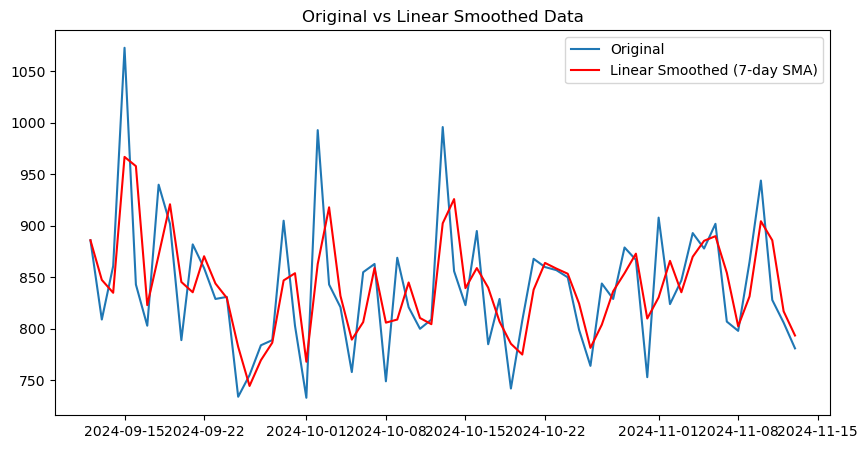

In [9]:
# Apply a rolling window of 7 days for smoothing (window siz can be adjusted)
daily_counts_smoothed_linear = daily_counts.rolling(window=2, min_periods=1).mean()

# Visualize the smoothed data
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(daily_counts, label='Original')
plt.plot(daily_counts_smoothed_linear, label='Linear Smoothed (7-day SMA)', color='red')
plt.legend()
plt.title("Original vs Linear Smoothed Data")
plt.show()

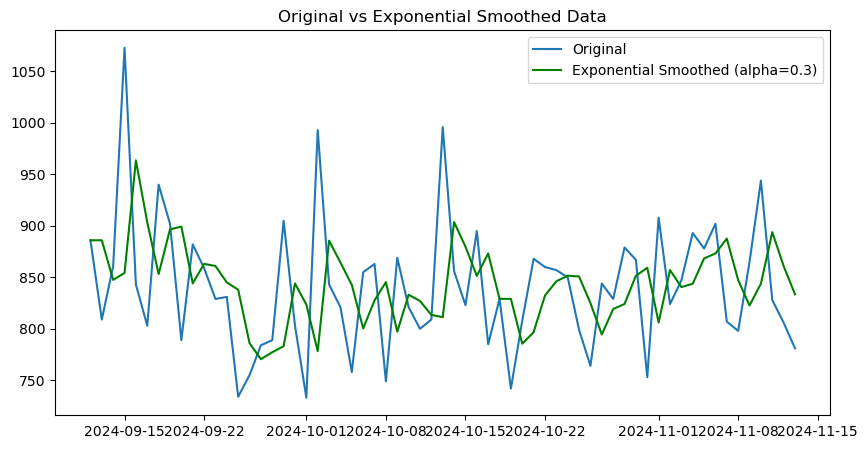

In [10]:
# Apply exponential smoothing with a smoothing level (alpha)
alpha = 0.5  # Smoothing factor; values close to 1 give more weight to recent values
model = SimpleExpSmoothing(daily_counts).fit(smoothing_level=alpha, optimized=False)
daily_counts_smoothed_exponential = model.fittedvalues.to_frame(name='vehicles_entered')

# Visualize the smoothed data
plt.figure(figsize=(10, 5))
plt.plot(daily_counts, label='Original')
plt.plot(daily_counts_smoothed_exponential, label='Exponential Smoothed (alpha=0.3)', color='green')
plt.legend()
plt.title("Original vs Exponential Smoothed Data")
plt.show()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.88624D+00    |proj g|=  8.03170D-01

At iterate    5    f=  4.48137D+00    |proj g|=  2.25078D-01

At iterate   10    f=  4.30754D+00    |proj g|=  2.91162D-01

At iterate   15    f=  4.29198D+00    |proj g|=  1.29165D-02

At iterate   20    f=  4.28713D+00    |proj g|=  5.27732D-02

At iterate   25    f=  4.28574D+00    |proj g|=  2.33783D-02

At iterate   30    f=  4.28496D+00    |proj g|=  5.74548D-03

At iterate   35    f=  4.28428D+00    |proj g|=  2.42484D-02


 This problem is unconstrained.



At iterate   40    f=  4.28306D+00    |proj g|=  3.20486D-02

At iterate   45    f=  4.28178D+00    |proj g|=  4.81012D-03

At iterate   50    f=  4.28122D+00    |proj g|=  1.72716D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     56      1     0     0   1.727D-02   4.281D+00
  F =   4.2812216248441652     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.91126D+00    |proj g|=  7.65980D-01

At iter

 This problem is unconstrained.



At iterate   45    f=  4.42248D+00    |proj g|=  1.98303D-02

At iterate   50    f=  4.41950D+00    |proj g|=  4.17797D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     62      1     0     0   4.178D-02   4.419D+00
  F =   4.4194958126381154     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


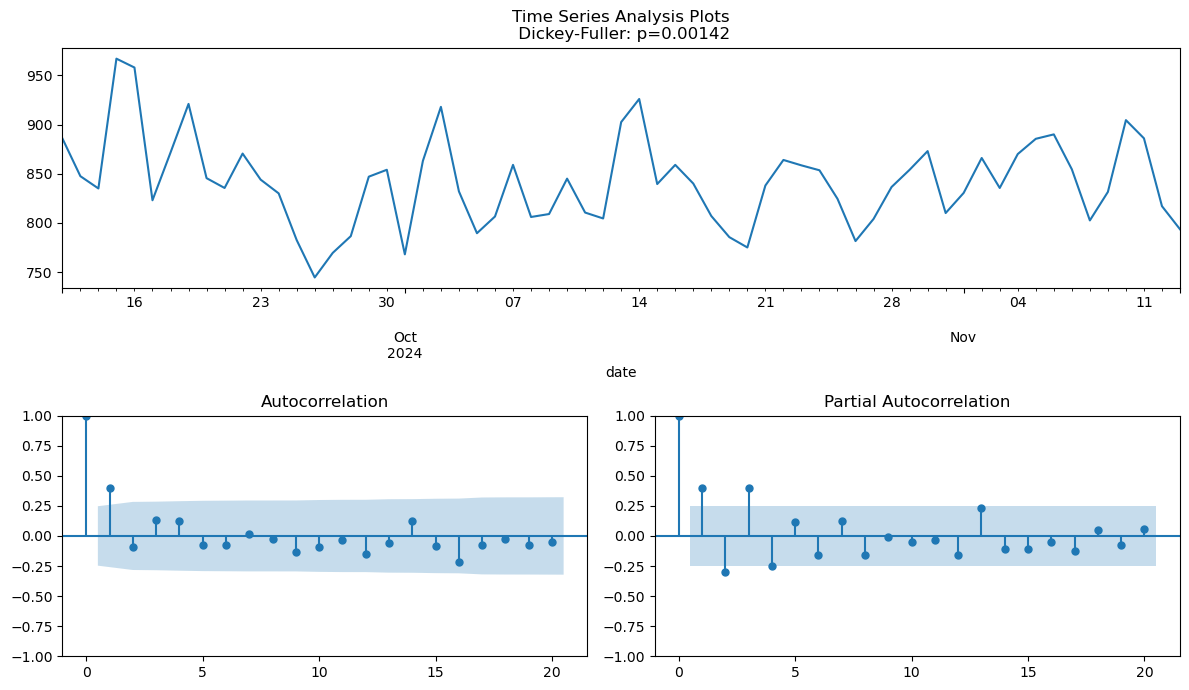

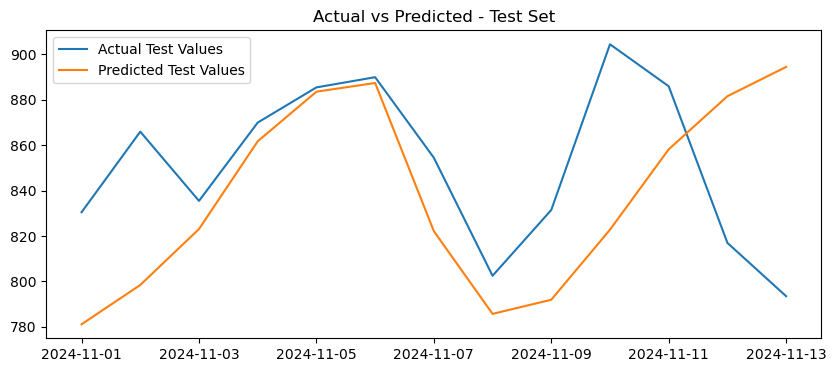

MAPE: 0.05, MASE: 0.96
Next 7-day Forecast:
 2024-11-14    775.704656
2024-11-15    781.566872
2024-11-16    786.541867
2024-11-17    848.459250
2024-11-18    899.073705
2024-11-19    846.629036
2024-11-20    832.227608
Freq: D, Name: predicted_mean, dtype: float64


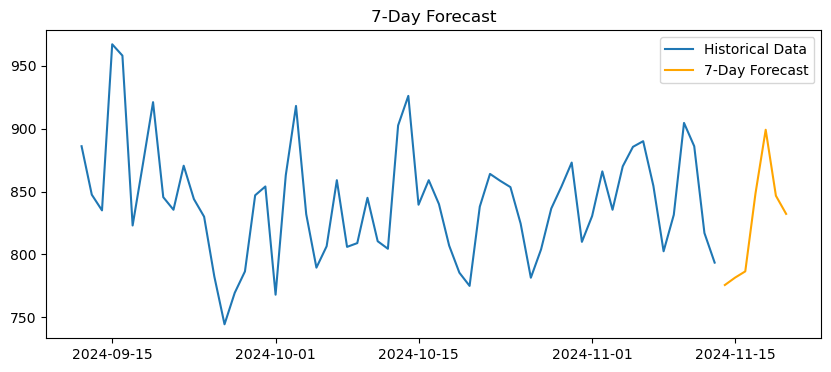

In [11]:
# Ensure your data has a DateTime index
# print(daily_counts_smoothed_linear)
daily_counts_smoothed_linear = daily_counts_smoothed_linear.asfreq('D')  # This assumes daily_counts is already a DataFrame
tsplot(daily_counts_smoothed_linear['vehicles_entered'], lags=20)


# Split into training and testing sets
train_size = int(len(daily_counts_smoothed_linear) * 0.8)  # 80% for training
train, test = daily_counts_smoothed_linear.iloc[:train_size], daily_counts_smoothed_linear.iloc[train_size:]

# SARIMAX Model fitting
# Adjust the (p, d, q) and (P, D, Q, s) parameters based on your data characteristics
model = SARIMAX(train['vehicles_entered'], order=(5, 0, 6), seasonal_order=(0, 1, 0, 7))  # Example parameters
model_fit = model.fit()

# Model for full dataset to make future predictions
full_model = SARIMAX(daily_counts_smoothed_linear['vehicles_entered'], order=(5, 0, 6), seasonal_order=(0, 1, 0, 7))
full_model_fit = full_model.fit()

# Make predictions for the test set
if not test.empty:
    test_forecast = model_fit.forecast(steps=len(test))
    # Plotting forecast vs actual values
    plt.figure(figsize=(10, 4))
    plt.plot(test.index, test['vehicles_entered'], label='Actual Test Values')
    plt.plot(test.index, test_forecast, label='Predicted Test Values')
    plt.title('Actual vs Predicted - Test Set')
    plt.legend()
    plt.show()

    # Calculate metrics
    mape = mean_absolute_percentage_error(test['vehicles_entered'], test_forecast)
    mase = mean_absolute_error(test['vehicles_entered'], test_forecast) / np.mean(np.abs(np.diff(train['vehicles_entered'])))
    print(f'MAPE: {mape:.2f}, MASE: {mase:.2f}')

# Forecast the next 7 days
forecast_steps = 7
future_forecast = full_model_fit.forecast(steps=forecast_steps)
print("Next 7-day Forecast:\n", future_forecast)

# Plot forecast
plt.figure(figsize=(10, 4))
plt.plot(daily_counts_smoothed_linear['vehicles_entered'], label='Historical Data')
plt.plot(pd.date_range(daily_counts_smoothed_linear.index[-1] + pd.Timedelta(days=1), periods=forecast_steps), future_forecast, label='7-Day Forecast', color='orange')
plt.title('7-Day Forecast')
plt.legend()
plt.show()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.11526D+00    |proj g|=  4.96988D-01

At iterate    5    f=  4.92716D+00    |proj g|=  1.22255D-01

At iterate   10    f=  4.90512D+00    |proj g|=  3.23120D-02

At iterate   15    f=  4.89609D+00    |proj g|=  2.67462D-02

At iterate   20    f=  4.89065D+00    |proj g|=  2.37511D-02

At iterate   25    f=  4.87017D+00    |proj g|=  2.82836D-02


 This problem is unconstrained.



At iterate   30    f=  4.86242D+00    |proj g|=  1.12949D-02

At iterate   35    f=  4.86168D+00    |proj g|=  1.58229D-03

At iterate   40    f=  4.86154D+00    |proj g|=  4.26967D-03

At iterate   45    f=  4.86057D+00    |proj g|=  3.08144D-03

At iterate   50    f=  4.86040D+00    |proj g|=  1.22621D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17     50     53      1     0     0   1.226D-02   4.860D+00
  F =   4.8603966989893079     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

 This problem is unconstrained.



At iterate   10    f=  4.85868D+00    |proj g|=  2.43429D-02

At iterate   15    f=  4.85459D+00    |proj g|=  1.46275D-02

At iterate   20    f=  4.84599D+00    |proj g|=  5.33265D-02

At iterate   25    f=  4.83894D+00    |proj g|=  1.46363D-02

At iterate   30    f=  4.83818D+00    |proj g|=  1.14760D-03

At iterate   35    f=  4.83808D+00    |proj g|=  3.93555D-03

At iterate   40    f=  4.83768D+00    |proj g|=  1.30587D-03

At iterate   45    f=  4.83767D+00    |proj g|=  3.27992D-04

At iterate   50    f=  4.83767D+00    |proj g|=  5.22721D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17     50     56   

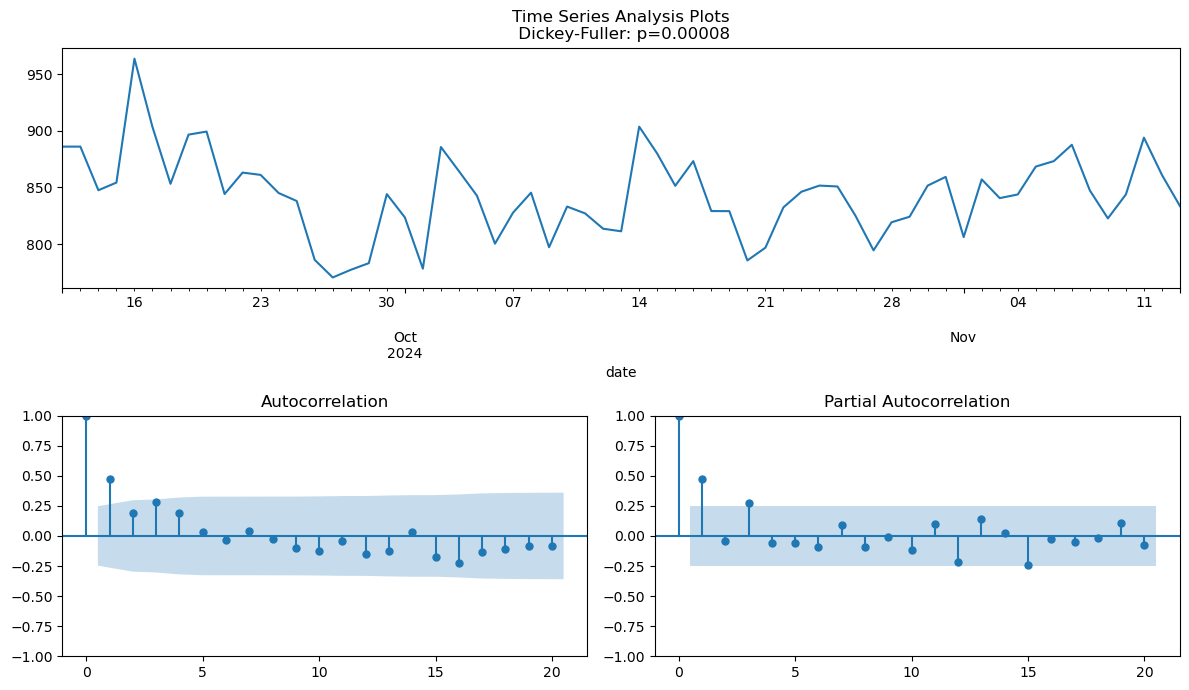

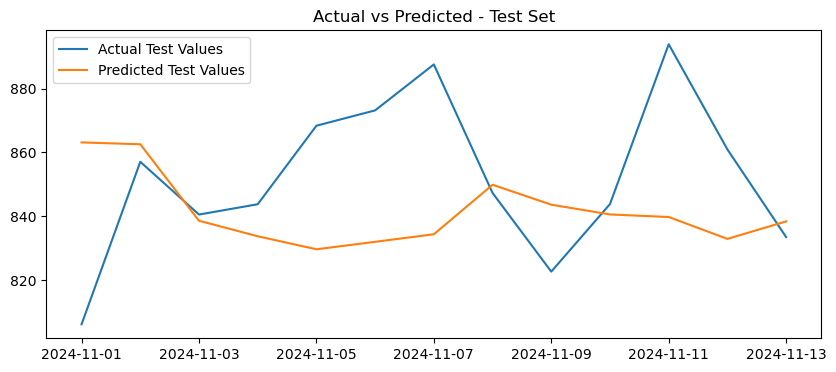

MAPE: 0.03, MASE: 0.86
Next 7-day Forecast:
 2024-11-14    839.399832
2024-11-15    846.364399
2024-11-16    851.005285
2024-11-17    830.975951
2024-11-18    851.469352
2024-11-19    854.390728
2024-11-20    846.425040
Freq: D, Name: predicted_mean, dtype: float64


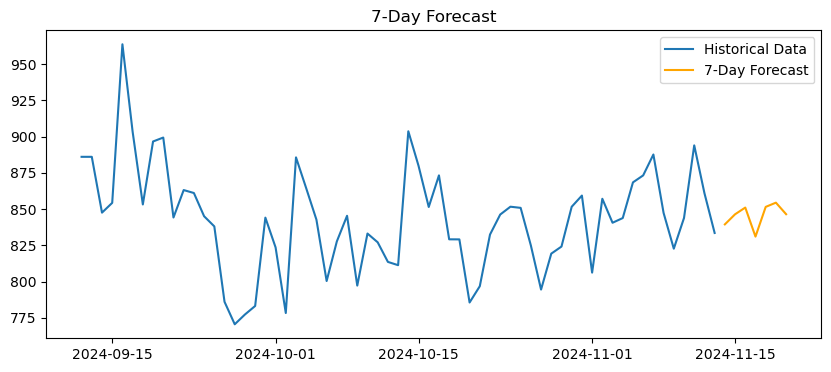

In [12]:
daily_counts_smoothed_exponential = daily_counts_smoothed_exponential.asfreq('D')  # This assumes daily_counts is already a DataFrame
tsplot(daily_counts_smoothed_exponential['vehicles_entered'], lags=20)


# Split into training and testing sets
train_size = int(len(daily_counts_smoothed_exponential) * 0.8)  # 80% for training
train, test = daily_counts_smoothed_exponential.iloc[:train_size], daily_counts_smoothed_exponential.iloc[train_size:]

# SARIMAX Model fitting
# Adjust the (p, d, q) and (P, D, Q, s) parameters based on your data characteristics
model = SARIMAX(train['vehicles_entered'], order=(14, 0, 1), seasonal_order=(0, 0, 1, 15))  # Example parameters
model_fit = model.fit()

# Model for full dataset to make future predictions
full_model = SARIMAX(daily_counts_smoothed_exponential['vehicles_entered'], order=(14, 0, 1), seasonal_order=(0, 0, 1, 15))
full_model_fit = full_model.fit()

# Make predictions for the test set
if not test.empty:
    test_forecast = model_fit.forecast(steps=len(test))
    # Plotting forecast vs actual values
    plt.figure(figsize=(10, 4))
    plt.plot(test.index, test['vehicles_entered'], label='Actual Test Values')
    plt.plot(test.index, test_forecast, label='Predicted Test Values')
    plt.title('Actual vs Predicted - Test Set')
    plt.legend()
    plt.show()

    # Calculate metrics
    mape = mean_absolute_percentage_error(test['vehicles_entered'], test_forecast)
    mase = mean_absolute_error(test['vehicles_entered'], test_forecast) / np.mean(np.abs(np.diff(train['vehicles_entered'])))
    print(f'MAPE: {mape:.2f}, MASE: {mase:.2f}')

# Forecast the next 7 days
forecast_steps = 7
future_forecast = full_model_fit.forecast(steps=forecast_steps)
print("Next 7-day Forecast:\n", future_forecast)

# Plot forecast
plt.figure(figsize=(10, 4))
plt.plot(daily_counts_smoothed_exponential['vehicles_entered'], label='Historical Data')
plt.plot(pd.date_range(daily_counts_smoothed_exponential.index[-1] + pd.Timedelta(days=1), periods=forecast_steps), future_forecast, label='7-Day Forecast', color='orange')
plt.title('7-Day Forecast')
plt.legend()
plt.show()

## For optimizing the 'b' part

In [13]:
q2_001 = df_entry[~df_entry['vehicle_no'].isin(unique_001['vehicle_no'])].sort_values(by='vehicle_no')
q2_002 = df_exit[~df_exit['vehicle_no'].isin(unique_002['vehicle_no'])].sort_values(by='vehicle_no')
q2_001 = q2_001[~q2_001['vehicle_no'].isin(Nan_001['vehicle_no'])].sort_values(by='vehicle_no')
q2_002 = q2_002[~q2_002['vehicle_no'].isin(Nan_002['vehicle_no'])].sort_values(by='vehicle_no')

# Sample data for demonstration (assuming q2_001 and q2_002 are already loaded DataFrames)
vehicle_no = ['MHWW1113', 'MHPY2628', 'MHBK0188', 'MHKA6372', 'MHYV2746', 'MHPH6142', 'MHSM0215', 'MHNO9764', 'MHCZ2221']
timestamp = ['2024-10-19 14:00:00', '2024-11-09 14:00:00', '2024-10-07 14:20:00', '2024-10-26 17:20:00', '2024-11-09 13:00:00', '2024-09-28 14:00:00', '2024-09-30 05:40:00', '2024-09-14 15:20:00', '2024-10-05 17:00:00']
camera_id = ['002', '002', '001', '002', '002', '002', '001', '001', '002']

# Assuming q2_001 and q2_002 are pre-loaded DataFrames that we want to update
for x, y, z in zip(vehicle_no, timestamp, camera_id):
    if z == '001':
        q2_001 = q2_001.query(f"vehicle_no != '{x}' or timestamp != '{y}' or camera_id != '{z}'")
    else:
        q2_002 = q2_002.query(f"vehicle_no != '{x}' or timestamp != '{y}' or camera_id != '{z}'")

print(q2_002.shape[0])
print(q2_001.shape[0])
q2_001.reset_index(drop= True, inplace = True)
# q2_001.to_csv('q2_001.csv', index=False)
q2_002.reset_index(drop= True, inplace = True)
# q2_002.to_csv('q2_002.csv', index=False)

52391
52391


In [14]:
# Convert the timestamp to datetime
q2_001['timestamp'] = pd.to_datetime(q2_001['timestamp'])
q2_002['timestamp'] = pd.to_datetime(q2_002['timestamp'])

# Add suffixes to each column name to distinguish between entry and exit
q2_001 = q2_001.add_suffix('_entry')
q2_002 = q2_002.add_suffix('_exit')

# Concatenate DataFrames row by row
merged_df = pd.concat([q2_001, q2_002], axis=1)

# Print merged DataFrame for verification
print("Merged DataFrame Row by Row:")
# print(merged_df)

# Calculate time spent in seconds
merged_df['time_spent'] = (merged_df['timestamp_exit'] - merged_df['timestamp_entry']).dt.total_seconds()

# Extract the date for grouping
merged_df['date'] = merged_df['timestamp_entry'].dt.date

# Group by date and vehicle_no to calculate the average time spent
average_time_spent = merged_df.groupby(['date'])['time_spent'].mean().reset_index()

# Convert seconds to a more readable format (hours)
average_time_spent['time_spent_hours'] = average_time_spent['time_spent'] / 3600
average_time_spent.set_index('date', inplace=True)
average_time_spent.drop(columns='time_spent',inplace=True)
# Output the result
print("\nAverage Time Spent:")
print(average_time_spent)

Merged DataFrame Row by Row:

Average Time Spent:
            time_spent_hours
date                        
2024-09-12          6.344788
2024-09-13         14.755639
2024-09-14          9.720342
2024-09-15         10.947105
2024-09-16          9.349282
2024-09-17          7.424812
2024-09-18          7.732047
2024-09-19          4.698359
2024-09-20          3.903553
2024-09-21          3.598028
2024-09-22          5.760724
2024-09-23          5.252929
2024-09-24          9.121249
2024-09-25          8.054870
2024-09-26          8.402423
2024-09-27          6.611397
2024-09-28          5.532562
2024-09-29          5.359462
2024-09-30          3.134341
2024-10-01          6.308676
2024-10-02          5.024100
2024-10-03          4.104887
2024-10-04          8.105911
2024-10-05          8.213049
2024-10-06          7.392619
2024-10-07          7.762738
2024-10-08          5.934056
2024-10-09          4.372731
2024-10-10          2.842536
2024-10-11          3.570042
2024-10-12          4.

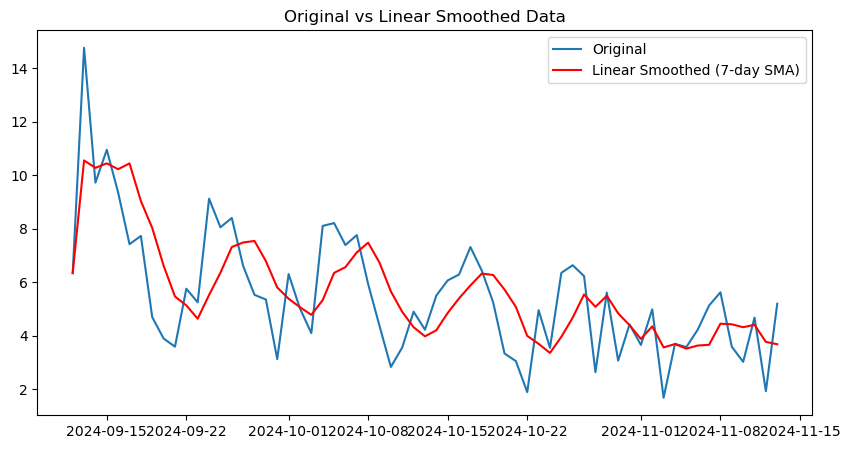

In [15]:
# Apply a rolling window of 7 days for smoothing (window siz can be adjusted)
average_time_spent_smoothed_linear = average_time_spent.rolling(window=5, min_periods=1).mean()

# Visualize the smoothed data
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(average_time_spent, label='Original')
plt.plot(average_time_spent_smoothed_linear, label='Linear Smoothed (7-day SMA)', color='red')
plt.legend()
plt.title("Original vs Linear Smoothed Data")
plt.show()

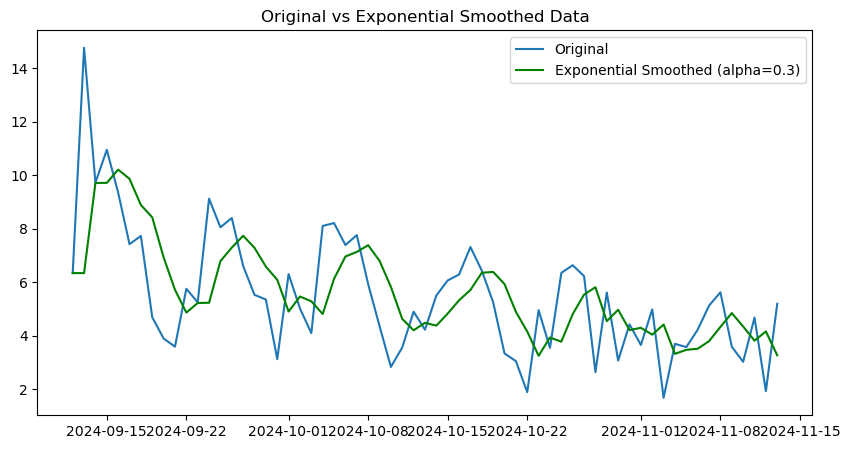

In [16]:
# Apply exponential smoothing with a smoothing level (alpha)
alpha = 0.4  # Smoothing factor; values close to 1 give more weight to recent values
model = SimpleExpSmoothing(average_time_spent).fit(smoothing_level=alpha, optimized=False)
average_time_spent_smoothed_exponential = model.fittedvalues.to_frame(name='time_spent_hours')

# Visualize the smoothed data
plt.figure(figsize=(10, 5))
plt.plot(average_time_spent, label='Original')
plt.plot(average_time_spent_smoothed_exponential, label='Exponential Smoothed (alpha=0.3)', color='green')
plt.legend()
plt.title("Original vs Exponential Smoothed Data")
plt.show()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.01926D+01    |proj g|=  2.11384D+02

At iterate    5    f=  9.64946D-01    |proj g|=  2.92415D-01

At iterate   10    f=  8.97790D-01    |proj g|=  5.34750D-02

At iterate   15    f=  8.80675D-01    |proj g|=  3.92305D-02

At iterate   20    f=  8.67651D-01    |proj g|=  2.20513D-02

At iterate   25    f=  8.61511D-01    |proj g|=  3.00603D-02

At iterate   30    f=  8.55877D-01    |proj g|=  2.13820D-02

At iterate   35    f=  8.54821D-01    |proj g|=  9.50123D-03


 This problem is unconstrained.



At iterate   40    f=  8.54737D-01    |proj g|=  4.16619D-03

At iterate   45    f=  8.54608D-01    |proj g|=  7.29318D-03

At iterate   50    f=  8.54559D-01    |proj g|=  1.51040D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     55      1     0     0   1.510D-03   8.546D-01
  F =  0.85455851717749642     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10086D+01    |proj g|=  9.03215D+01

At iter

 This problem is unconstrained.



At iterate   45    f=  7.69009D-01    |proj g|=  2.62030D-03

At iterate   50    f=  7.68959D-01    |proj g|=  2.10214D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     58      1     0     0   2.102D-03   7.690D-01
  F =  0.76895888375972798     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


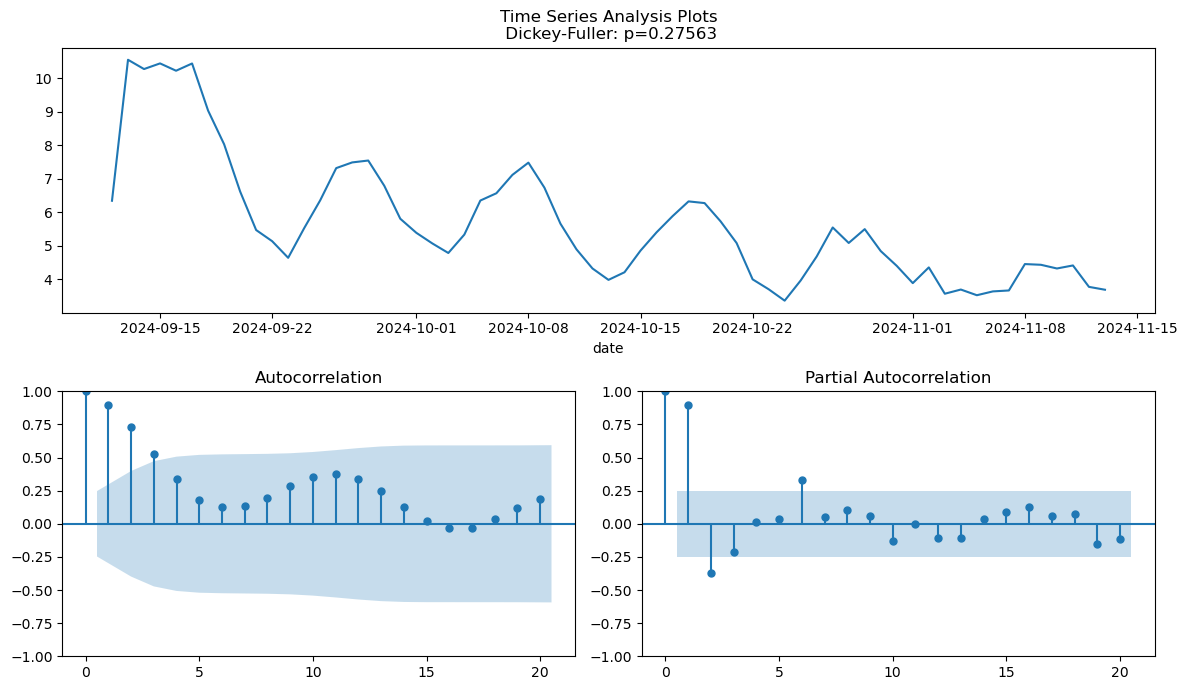

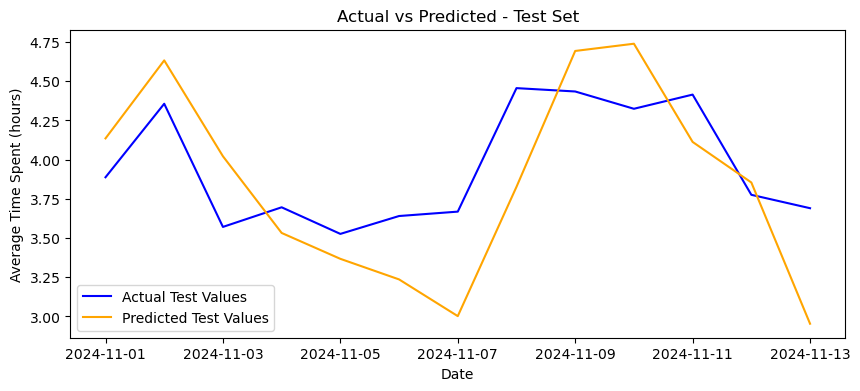

MAPE: 0.09, MASE: 0.56
2024-11-14    3.794180
2024-11-15    4.017193
2024-11-16    3.751158
2024-11-17    3.847062
2024-11-18    3.495287
2024-11-19    2.875013
2024-11-20    3.041984
Freq: D, Name: predicted_mean, dtype: float64


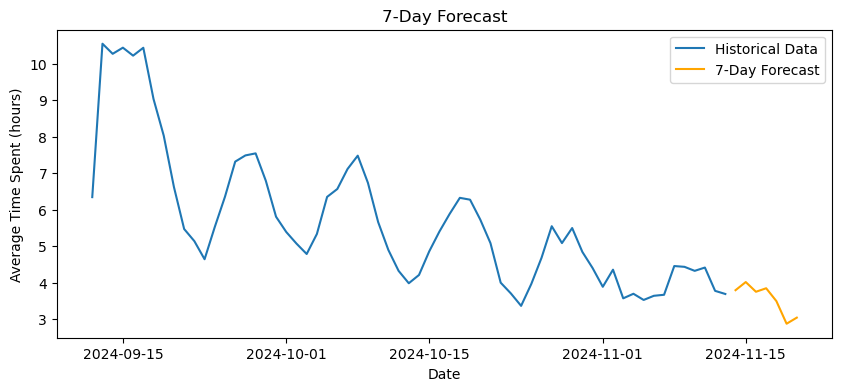

In [17]:
# Plotting the time series, ACF, and PACF
tsplot(average_time_spent_smoothed_linear['time_spent_hours'], lags=20)

# Split into training and testing sets
train_size_time = int(len(average_time_spent_smoothed_linear) * 0.8)  # 80% for training
train_time, test_time = average_time_spent_smoothed_linear.iloc[:train_size_time], average_time_spent_smoothed_linear.iloc[train_size_time:]

# SARIMAX Model fitting
model_time = SARIMAX(train_time['time_spent_hours'], order=(5, 1, 7), seasonal_order=(0, 1, 0, 7))  # Example parameters
model_fit_time = model_time.fit()

# Model for the full dataset to make future predictions
full_model_time = SARIMAX(average_time_spent_smoothed_linear['time_spent_hours'], order=(5, 1, 7), seasonal_order=(0, 1, 0, 7))
full_model_fit_time = full_model_time.fit()

# Make predictions for the test set
if not test.empty:
    test_forecast_time = model_fit_time.forecast(steps=len(test_time))
    
    # Plotting forecast vs actual values
    plt.figure(figsize=(10, 4))
    plt.plot(test_time.index, test_time['time_spent_hours'], label='Actual Test Values', color='blue')
    plt.plot(test_time.index, test_forecast_time, label='Predicted Test Values', color='orange')
    plt.title('Actual vs Predicted - Test Set')
    plt.xlabel('Date')
    plt.ylabel('Average Time Spent (hours)')
    plt.legend()
    plt.show()

    # Calculate metrics
    mape = mean_absolute_percentage_error(test_time['time_spent_hours'], test_forecast_time)
    mase = mean_absolute_error(test_time['time_spent_hours'], test_forecast_time) / np.mean(np.abs(np.diff(train_time['time_spent_hours'])))
    print(f'MAPE: {mape:.2f}, MASE: {mase:.2f}')

# Forecast the next 7 days
forecast_steps = 7
future_forecast_time = full_model_fit_time.forecast(steps=forecast_steps)
print(future_forecast_time)

# Prepare the date index for the forecast using the last date in the index
forecast_dates = pd.date_range(start=average_time_spent_smoothed_linear.index[-1] + pd.Timedelta(days=1), periods=forecast_steps)

# Plot the forecast
plt.figure(figsize=(10, 4))
plt.plot(average_time_spent_smoothed_linear['time_spent_hours'], label='Historical Data')
plt.plot(forecast_dates, future_forecast_time, label='7-Day Forecast', color='orange')
plt.title('7-Day Forecast')
plt.xlabel('Date')
plt.ylabel('Average Time Spent (hours)')
plt.legend()
plt.show()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.97050D+09    |proj g|=  2.93902D+14

At iterate    5    f=  9.94635D+02    |proj g|=  8.06236D+04

At iterate   10    f=  1.34050D+02    |proj g|=  4.05008D+03

At iterate   15    f=  1.68982D+01    |proj g|=  1.92731D+02


 This problem is unconstrained.



At iterate   20    f=  2.12189D+00    |proj g|=  7.86830D+00

At iterate   25    f=  8.89058D-01    |proj g|=  8.41620D-02

At iterate   30    f=  8.38654D-01    |proj g|=  1.00624D-01

At iterate   35    f=  8.00039D-01    |proj g|=  1.27427D-01

At iterate   40    f=  7.89863D-01    |proj g|=  9.05870D-02

At iterate   45    f=  7.73481D-01    |proj g|=  1.15268D-01

At iterate   50    f=  7.65636D-01    |proj g|=  4.39881D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15     50     68      1     0     0   4.399D-02   7.656D-01
  F =  0.76563598613023653     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate    5    f=  9.11245D-01    |proj g|=  1.71488D-01

At iterate   10    f=  8.58328D-01    |proj g|=  6.34210D-02

At iterate   15    f=  8.14589D-01    |proj g|=  4.69194D-02

At iterate   20    f=  8.05817D-01    |proj g|=  3.00045D-02

At iterate   25    f=  8.00569D-01    |proj g|=  1.42108D-02

At iterate   30    f=  7.99405D-01    |proj g|=  1.10853D-02

At iterate   35    f=  7.99044D-01    |proj g|=  1.79899D-02

At iterate   40    f=  7.98479D-01    |proj g|=  1.32380D-02

At iterate   45    f=  7.98041D-01    |proj g|=  2.06599D-02

At iterate   50    f=  7.97853D-01    |proj g|=  2.93537D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

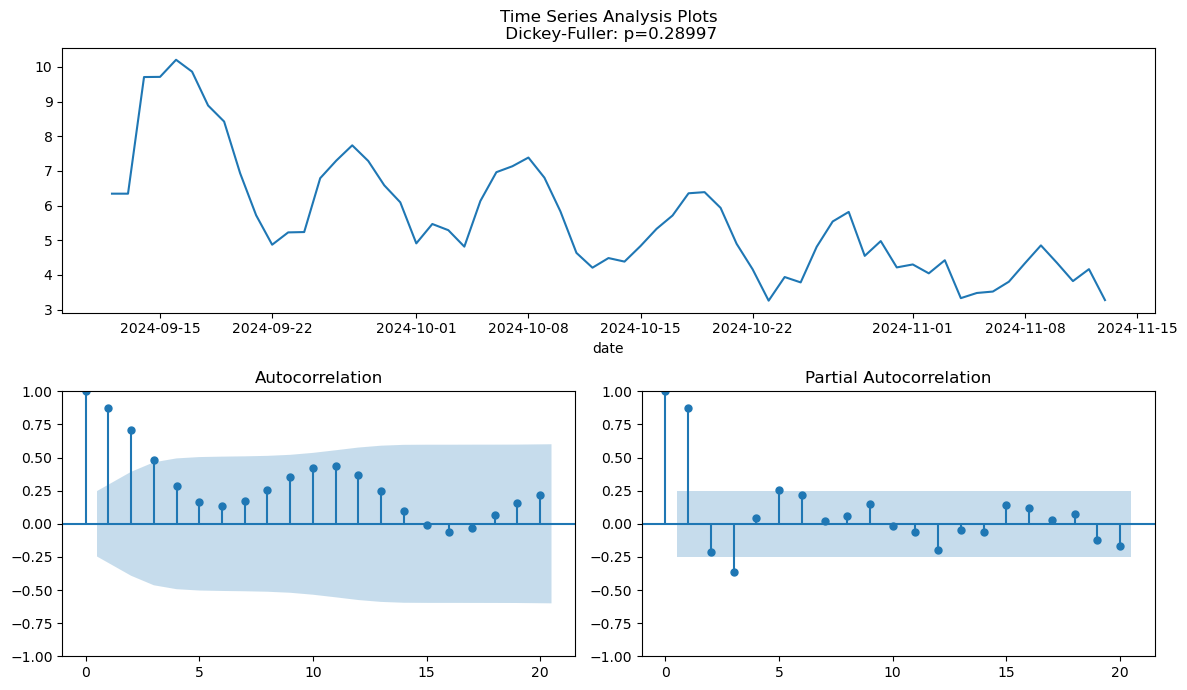

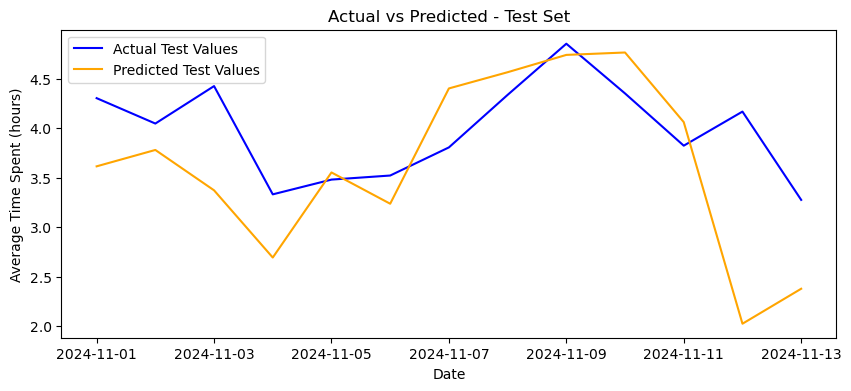

MAPE: 0.15, MASE: 0.88
2024-11-14    3.559771
2024-11-15    3.935967
2024-11-16    3.504107
2024-11-17    4.466666
2024-11-18    3.634012
2024-11-19    2.706406
2024-11-20    2.689893
Freq: D, Name: predicted_mean, dtype: float64


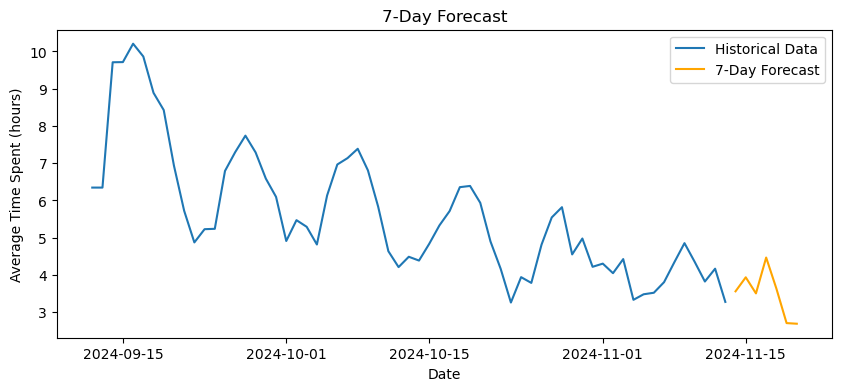

In [18]:
# Plotting the time series, ACF, and PACF
tsplot(average_time_spent_smoothed_exponential['time_spent_hours'], lags=20)

# Split into training and testing sets
train_size_time = int(len(average_time_spent_smoothed_exponential) * 0.8)  # 80% for training
train_time, test_time = average_time_spent_smoothed_exponential.iloc[:train_size_time], average_time_spent_smoothed_exponential.iloc[train_size_time:]

# SARIMAX Model fitting
model_time = SARIMAX(train_time['time_spent_hours'], order=(7, 1, 7), seasonal_order=(0, 1, 0, 14))  # Example parameters
model_fit_time = model_time.fit()

# Model for the full dataset to make future predictions
full_model_time = SARIMAX(average_time_spent_smoothed_exponential['time_spent_hours'], order=(7, 1, 7), seasonal_order=(0, 1, 0, 14))
full_model_fit_time = full_model_time.fit()

# Make predictions for the test set
if not test.empty:
    test_forecast_time = model_fit_time.forecast(steps=len(test_time))
    
    # Plotting forecast vs actual values
    plt.figure(figsize=(10, 4))
    plt.plot(test_time.index, test_time['time_spent_hours'], label='Actual Test Values', color='blue')
    plt.plot(test_time.index, test_forecast_time, label='Predicted Test Values', color='orange')
    plt.title('Actual vs Predicted - Test Set')
    plt.xlabel('Date')
    plt.ylabel('Average Time Spent (hours)')
    plt.legend()
    plt.show()

    # Calculate metrics
    mape = mean_absolute_percentage_error(test_time['time_spent_hours'], test_forecast_time)
    mase = mean_absolute_error(test_time['time_spent_hours'], test_forecast_time) / np.mean(np.abs(np.diff(train_time['time_spent_hours'])))
    print(f'MAPE: {mape:.2f}, MASE: {mase:.2f}')

# Forecast the next 7 days
forecast_steps = 7
future_forecast_time = full_model_fit_time.forecast(steps=forecast_steps)
print(future_forecast_time)

# Prepare the date index for the forecast using the last date in the index
forecast_dates = pd.date_range(start=average_time_spent_smoothed_exponential.index[-1] + pd.Timedelta(days=1), periods=forecast_steps)

# Plot the forecast
plt.figure(figsize=(10, 4))
plt.plot(average_time_spent_smoothed_exponential['time_spent_hours'], label='Historical Data')
plt.plot(forecast_dates, future_forecast_time, label='7-Day Forecast', color='orange')
plt.title('7-Day Forecast')
plt.xlabel('Date')
plt.ylabel('Average Time Spent (hours)')
plt.legend()
plt.show()